In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
train_features=torch.load('train_features.pt')
train_labels=torch.load('train_labels.pt')

In [4]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([1704759, 14])
torch.Size([1704759])


In [5]:
train = torch.cat([train_features, train_labels.reshape(-1,1)],1)
print(train.shape)
train = train[torch.randperm(train.size(0))] #shuffling dataset, parameter down need to be updated
train_set = train[0:1500000,                            0:train.shape[1]-1]
train_label = train[0:1500000,                          train.shape[1]-1]
validation_set = train[1500000:1600000,                 0:train.shape[1]-1]
validation_label = train[1500000:1600000,               train.shape[1]-1]
test_set = train[1600000:train.shape[0],                0:train.shape[1]-1]
test_label = train[1600000:train.shape[0],              train.shape[1]-1]

torch.Size([1704759, 15])


In [6]:
train_set

tensor([[ 0.0000,  0.0000, 11.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.4963,  1.9732,  3.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-1.0353,  1.3840,  3.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  5.0000,  ...,  0.0000,  1.0000,  0.0000]])

In [7]:
print(test_set.shape)

torch.Size([104759, 14])


In [71]:
#You may save them if you want
torch.save(train_set,'train_set.pt')
torch.save(train_label,'train_label.pt')
torch.save(validation_set,'validation_set.pt')
torch.save(validation_label,'validation_label.pt')
torch.save(test_set,'test_set.pt')
torch.save(test_label,'test_label.pt')

In [8]:
del train_features
del train_labels

In [9]:
print(train_set.dtype)
print(train_label.dtype)

torch.float32
torch.float32


In [10]:
train_set.shape

torch.Size([1500000, 14])

In [12]:
device

device(type='cuda')

In [13]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x


In [40]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output_layer(x)
        return x


In [14]:
# Number of features in your data and the size of the hidden layer
input_features = train_set.shape[1]
hidden_size = 10

# Initialize the model and move to the device
model = MLP(input_features, hidden_size)
model = model.to(device)


In [15]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y) + self.eps)


In [22]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 60
BATCH_SIZE = 128

In [23]:
train_dataset = TensorDataset(train_set, train_label)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(validation_set, validation_label)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


print(len(train_loader))
all_losses = []
train_loss = []

11719


In [18]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [19]:
def train(model, train_loader, val_loader, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        group_320_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            group_320_loss += loss.item()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch+1} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        print(f"Epoch: {epoch+1} Validation Loss:{val_loss/len(val_loader)}")




In [ ]:
learning_rates = [1e-3, 1e-4, 1e-5]
weight_decays = [1e-3, 1e-4, 1e-5]
hidden_sizes = [10,20,30]

best_val_loss = float('inf')
best_hyperparameters = None
best_hidden_sizes = 10

for lr in learning_rates:
    for wd in weight_decays:
        for hs in hidden_sizes:
            print(f"Training with learning rate {lr} and weight decay {wd} and hidden size {hs}")
            model = MLP(train_set.shape[1],hs).to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            train(model, train_loader, val_loader, criterion, num_epochs) # use the training function you defined
            val_loss = validate(model, val_loader, criterion) # you will need to define a validate function
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_hyperparameters = (lr, wd,hs)

print(f"Best validation loss: {best_val_loss}")
print(f"Best hyperparameters: learning rate {best_hyperparameters[0]}, weight decay {best_hyperparameters[1]}, weight decay {best_hyperparameters[2]}")


Training with learning rate 0.001 and weight decay 0.001
Epoch: 1 Training Loss:583.0806999795723
Epoch: 1 Validation Loss:566.7689950836826
Epoch: 2 Training Loss:574.1835774567278
Epoch: 2 Validation Loss:564.5013587741767
Epoch: 3 Training Loss:573.2573976904899
Epoch: 3 Validation Loss:566.017265920218
Epoch: 4 Training Loss:573.430598250753
Epoch: 4 Validation Loss:567.0644404727987
Epoch: 5 Training Loss:573.5424430991045
Epoch: 5 Validation Loss:563.7239495275575
Training with learning rate 0.001 and weight decay 0.001
Epoch: 1 Training Loss:578.8068972920505
Epoch: 1 Validation Loss:566.2679922112424
Epoch: 2 Training Loss:573.2519973395515
Epoch: 2 Validation Loss:564.0583711259272
Epoch: 3 Training Loss:572.6715437486032
Epoch: 3 Validation Loss:565.0921165969078
Epoch: 4 Training Loss:572.6074808157999
Epoch: 4 Validation Loss:565.458114848561
Epoch: 5 Training Loss:572.8957098485545
Epoch: 5 Validation Loss:563.8831811906127
Training with learning rate 0.001 and weight deca

In [41]:

model = MLP(train_set.shape[1],10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train(model, train_loader, val_loader, criterion, num_epochs)

Epoch: 1 Training Loss:609.7405943256543
Epoch: 1 Validation Loss:602.8787796918084
Epoch: 2 Training Loss:600.6609992424328
Epoch: 2 Validation Loss:600.3429184155086
Epoch: 3 Training Loss:600.1730779951695
Epoch: 3 Validation Loss:600.0911054684378
Epoch: 4 Training Loss:599.20798015684
Epoch: 4 Validation Loss:600.6726559299947
Epoch: 5 Training Loss:599.9125004057205
Epoch: 5 Validation Loss:603.0949666445213
Epoch: 6 Training Loss:599.5090559265985
Epoch: 6 Validation Loss:600.3225181950328
Epoch: 7 Training Loss:599.1851631592276
Epoch: 7 Validation Loss:602.6141812063544
Epoch: 8 Training Loss:599.7139676358779
Epoch: 8 Validation Loss:601.3491472405241
Epoch: 9 Training Loss:598.9564692411562
Epoch: 9 Validation Loss:599.2540269934613
Epoch: 10 Training Loss:598.8608417317306
Epoch: 10 Validation Loss:598.7346404873197
Epoch: 11 Training Loss:599.0900915520052
Epoch: 11 Validation Loss:599.5697535053848
Epoch: 12 Training Loss:598.9871480736535
Epoch: 12 Validation Loss:601.14

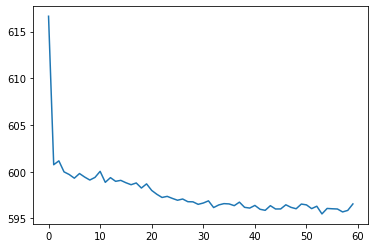

In [28]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

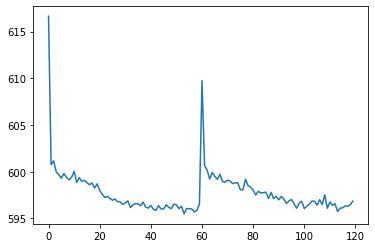

In [42]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

In [37]:
del all_losses

In [24]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [ ]:
#You need to see loss for validation set to tune the parameter. I didn't do that because linear regression is too simple

In [39]:
print(view_loss(model, test_set, test_label,criterion)/test_set.shape[0]*320)

tensor(2800.0242, device='cuda:0', grad_fn=<MulBackward0>)


In [29]:
predict_input = torch.load('predict_input.pt').to(device)
print(predict_input.shape)

torch.Size([320, 14])


In [30]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [32]:
out = predict(model)
print(out)

tensor([[907.8166],
        [834.1433],
        [907.8166],
        [853.2374],
        [828.6076],
        [892.8090],
        [907.8166],
        [892.8090],
        [837.2757],
        [907.8166],
        [728.0526],
        [949.9908],
        [949.9908],
        [949.9908],
        [949.9908],
        [949.9908],
        [949.9908],
        [949.9908],
        [907.8166],
        [949.9908],
        [907.8166],
        [892.8090],
        [892.8090],
        [907.8166],
        [809.0719],
        [880.5782],
        [907.8166],
        [907.8166],
        [786.9183],
        [907.8166],
        [907.8166],
        [834.1433],
        [949.9908],
        [949.9908],
        [949.9908],
        [949.9908],
        [892.8090],
        [812.8345],
        [907.8166],
        [856.8908],
        [772.9594],
        [949.9908],
        [949.9908],
        [837.2757],
        [819.7927],
        [815.0016],
        [949.9908],
        [949.9908],
        [684.4656],
        [728.0526],


In [43]:
out = predict(model)
print(out)

tensor([[ 915.4891],
        [ 820.9103],
        [ 915.4891],
        [ 854.3281],
        [ 817.9877],
        [ 906.7170],
        [ 915.4891],
        [ 906.7170],
        [ 876.6290],
        [ 915.4891],
        [ 715.3895],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 915.4891],
        [ 928.2835],
        [ 915.4891],
        [ 906.7170],
        [ 906.7170],
        [ 915.4891],
        [ 806.2587],
        [ 786.5085],
        [ 915.4891],
        [ 915.4891],
        [ 797.7747],
        [ 915.4891],
        [ 915.4891],
        [ 820.9103],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 928.2835],
        [ 906.7170],
        [ 808.2930],
        [ 915.4891],
        [ 848.8781],
        [ 783.6944],
        [ 928.2835],
        [ 928.2835],
        [ 876.6290],
        [ 810.4292],
        [ 840.0967],
        [ 928.2835],
        [ 928

In [45]:
linear_predict = pd.read_csv('test_public.csv')
linear_predict = linear_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
linear_predict= pd.concat([linear_predict, pd.DataFrame(predict_tensor)], axis=1)
linear_predict = linear_predict.rename(columns={0: 'TRAVEL_TIME'})
linear_predict.head()

,TRIP_ID,TRAVEL_TIME
0,T1,915.489075
1,T2,820.910278
2,T3,915.489075
3,T4,854.328064
4,T5,817.987732


In [46]:
linear_predict.to_csv('4_layer_MLP_predict.csv', index=False)

In [38]:
PATH = '2_layers_60ep_MLP.pth'
torch.save(model.state_dict(),PATH)

In [77]:
model = MLP(14,10).to(device)
model_state = torch.load('linear.pth')
model.load_state_dict(model_state)

<All keys matched successfully>

In [35]:
predict_input

tensor([[-1.0353,  1.3840,  8.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-1.2917,  0.4417,  8.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-1.0353,  1.3840,  8.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000, 12.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.0000,  ...,  1.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [ ]:
#Use sklearn for something like gradient boosting or random forest

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

In [ ]:
#TODO: build other models
#TODO: report loss on validation sets and tune parameters for each model
#TODO: run on test sets and report test loss
#TODO: predict travel time(test_features) and submit to kaggle